In [35]:
!pip install sentence-transformers
!pip install pandas


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable


In [36]:


from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import torch
import random
import torch
import random

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [37]:
#Load the sprag dataset
data = pd.read_csv("refstdcombined.csv")
data.head(2)

,Unnamed: 0,QuestionID,ReferenceAnswer,StudentAnswer,Score1,Score2,avg_score,max_score
0,0.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tha object structures which can be changeable ...,1.0,0.0,0.5,1.0
1,1.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tuple,0.0,0.0,0.0,0.0


In [38]:
data['bin_score'] = data.apply(lambda row : 1 if row.avg_score>=3 else 0, axis=1)

In [39]:
data.head(2)

,Unnamed: 0,QuestionID,ReferenceAnswer,StudentAnswer,Score1,Score2,avg_score,max_score,bin_score
0,0.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tha object structures which can be changeable ...,1.0,0.0,0.5,1.0,0
1,1.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tuple,0.0,0.0,0.0,0.0,0


In [40]:
data = data.dropna()

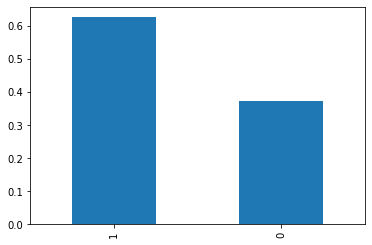

In [41]:
data['bin_score'].value_counts(normalize=True).plot(kind='bar');

In [42]:
#### Just some code to print debug information to stdout
import logging
from sentence_transformers import LoggingHandler
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

In [43]:
from sklearn.model_selection import train_test_split

# Storing labels in array
labels = data['bin_score'].values

# Dropping labels column from data
data = data.drop(['bin_score'], axis=1)

# Splitting data into train and test sets in a 70/30 ratio
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, stratify=labels, random_state=42, test_size=0.2)

In [44]:
len(train_data)*0.5, type(train_labels), train_labels.shape


(1604.0, numpy.ndarray, (3208,))

In [45]:
train_data = train_data.iloc[0:1604]
train_labels = train_labels[0:1604]

In [46]:
type(train_data), type(train_labels), len(train_data), len(train_labels)

(pandas.core.frame.DataFrame, numpy.ndarray, 1604, 1604)

In [47]:
def random_swap(sentence, n=2): 
    sentence = sentence.split()
    if len(sentence) > 4:

      length = range(len(sentence)-1) 
      #print(sentence, length)
      for _ in range(n):
          idx1, idx2 = random.sample(length, 2)
          sentence[idx1], sentence[idx2] = sentence[idx2], sentence[idx1] 
          #print(idx1, idx2, sentence)
      return ' '.join(sentence)
    return ' '.join(sentence)

In [48]:
random_swap("Hi i am there where are you")

'Hi am i there are where you'

In [49]:
def sentence_pairs_generation(sentence1, sentence2, labels, pairs, datatype='train'):
	# initialize two empty lists to hold the (sentence, sentence) pairs and
	# labels to indicate if the grade of the pair

  numClassesList = np.unique(labels)
  #print(numClassesList)
  idx = [np.where(labels == i)[0] for i in numClassesList]
  #print(idx)
  i=0

  for idxA in range(len(sentence1)):      
    dAns = sentence1[idxA]
    sAns = sentence2[idxA]
    label = int(labels[idxA])
    
		  # prepare a pair and update the sentences and labels lists, respectively
    pairs.append(InputExample(texts=[dAns, sAns], label=label))
    
    if datatype=='train' and random.random() >= 0.5:
      sAns = random_swap(sentence2[idxA])
      #print(sAns)
      pairs.append(InputExample(texts=[dAns, sAns], label=label))
      i = i+1
  
  print("No.of augmented examples : ", i)

     
	# return a 2-tuple of our image pairs and labels
  return (pairs)

In [50]:
set_seed(0)
# Equal samples per class training
#train_df_sample = pd.concat([train_df[train_df[1]==0].sample(num_training), train_df[train_df[1]==1].sample(num_training)])
x_train_dA = train_data['ReferenceAnswer'].values.tolist()
x_train_sA = train_data['StudentAnswer'].values.tolist()
y_train = train_labels.tolist()
y_train = [int(x) for x in y_train]

In [51]:
#use test dataset as dev dataset
x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels / 1.0
y_test = test_labels.tolist()
#y_test = [int(x) for x in y_test]

test_examples = [] 
test_examples = sentence_pairs_generation(np.array(x_test_dA), np.array(x_test_sA), np.array(y_test), test_examples, datatype='test')

No.of augmented examples :  0


In [52]:
len(test_examples)

802

In [53]:
train_examples = [] 
train_examples = sentence_pairs_generation(np.array(x_train_dA), np.array(x_train_sA), np.array(y_train), train_examples)

No.of augmented examples :  791


In [54]:
len(train_examples)

2395

In [55]:
# Save path of the model
from datetime import datetime
model_save_path = 'output/training_sprag_v4_'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [56]:
from sentence_transformers import evaluation
import math


def train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs,model_save_path):
  model = SentenceTransformer(st_model)
  #for evaluation
  train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
  #test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
  x_test_dA = test_data['ReferenceAnswer'].values.tolist()
  x_test_sA = test_data['StudentAnswer'].values.tolist()
  y_test = test_labels 

  evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)

  #configuring the training
  warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
  print(warmup_steps)
  #train_loss = losses.CosineSimilarityLoss(model)
  model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          show_progress_bar=True,  
          #evaluation_steps=50, 
          output_path=model_save_path,)
  print("Training done...")

In [57]:
st_model = 'stsb-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


2022-09-07 20:42:34 - Load pretrained SentenceTransformer: stsb-distilbert-base
2022-09-07 20:42:35 - Use pytorch device: cuda
2022-09-07 20:42:35 - Softmax loss: #Vectors concatenated: 3
150


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:42:47 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2022-09-07 20:42:48 - Accuracy with Cosine-Similarity:           77.18	(Threshold: 0.4002)
2022-09-07 20:42:48 - F1 with Cosine-Similarity:                 83.38	(Threshold: 0.3385)
2022-09-07 20:42:48 - Precision with Cosine-Similarity:          74.76
2022-09-07 20:42:48 - Recall with Cosine-Similarity:             94.23
2022-09-07 20:42:48 - Average Precision with Cosine-Similarity:  89.50

2022-09-07 20:42:48 - Accuracy with Manhattan-Distance:           76.81	(Threshold: 342.6188)
2022-09-07 20:42:48 - F1 with Manhattan-Distance:                 83.58	(Threshold: 393.6622)
2022-09-07 20:42:48 - Precision with Manhattan-Distance:          74.84
2022-09-07 20:42:48 - Recall with Manhattan-Distance:             94.63
2022-09-07 20:42:48 - Average Precision with Manhattan-Distance:  89.78

2022-09-07 20:42:48 - Accuracy with Euclidean-Distance:           77.18	(Threshold: 16.0068)
2022-09-07 20:42:

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:43:01 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2022-09-07 20:43:01 - Accuracy with Cosine-Similarity:           81.67	(Threshold: 0.4304)
2022-09-07 20:43:01 - F1 with Cosine-Similarity:                 85.93	(Threshold: 0.4304)
2022-09-07 20:43:01 - Precision with Cosine-Similarity:          82.84
2022-09-07 20:43:01 - Recall with Cosine-Similarity:             89.26
2022-09-07 20:43:01 - Average Precision with Cosine-Similarity:  91.62

2022-09-07 20:43:01 - Accuracy with Manhattan-Distance:           81.42	(Threshold: 378.1932)
2022-09-07 20:43:01 - F1 with Manhattan-Distance:                 86.09	(Threshold: 380.9424)
2022-09-07 20:43:01 - Precision with Manhattan-Distance:          81.16
2022-09-07 20:43:01 - Recall with Manhattan-Distance:             91.65
2022-09-07 20:43:01 - Average Precision with Manhattan-Distance:  91.74

2022-09-07 20:43:01 - Accuracy with Euclidean-Distance:           81.42	(Threshold: 16.8388)
2022-09-07 20:43:

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:43:15 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2022-09-07 20:43:15 - Accuracy with Cosine-Similarity:           81.67	(Threshold: 0.2562)
2022-09-07 20:43:15 - F1 with Cosine-Similarity:                 86.60	(Threshold: 0.2562)
2022-09-07 20:43:15 - Precision with Cosine-Similarity:          79.97
2022-09-07 20:43:15 - Recall with Cosine-Similarity:             94.43
2022-09-07 20:43:15 - Average Precision with Cosine-Similarity:  91.32

2022-09-07 20:43:15 - Accuracy with Manhattan-Distance:           81.55	(Threshold: 414.9041)
2022-09-07 20:43:15 - F1 with Manhattan-Distance:                 86.44	(Threshold: 433.5207)
2022-09-07 20:43:15 - Precision with Manhattan-Distance:          79.27
2022-09-07 20:43:15 - Recall with Manhattan-Distance:             95.03
2022-09-07 20:43:15 - Average Precision with Manhattan-Distance:  91.47

2022-09-07 20:43:15 - Accuracy with Euclidean-Distance:           81.92	(Threshold: 19.0494)
2022-09-07 20:43:

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:43:27 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2022-09-07 20:43:28 - Accuracy with Cosine-Similarity:           81.17	(Threshold: 0.2354)
2022-09-07 20:43:28 - F1 with Cosine-Similarity:                 86.13	(Threshold: 0.2354)
2022-09-07 20:43:28 - Precision with Cosine-Similarity:          80.03
2022-09-07 20:43:28 - Recall with Cosine-Similarity:             93.24
2022-09-07 20:43:28 - Average Precision with Cosine-Similarity:  90.43

2022-09-07 20:43:28 - Accuracy with Manhattan-Distance:           81.30	(Threshold: 440.5962)
2022-09-07 20:43:28 - F1 with Manhattan-Distance:                 86.36	(Threshold: 445.8483)
2022-09-07 20:43:28 - Precision with Manhattan-Distance:          79.56
2022-09-07 20:43:28 - Recall with Manhattan-Distance:             94.43
2022-09-07 20:43:28 - Average Precision with Manhattan-Distance:  90.60

2022-09-07 20:43:28 - Accuracy with Euclidean-Distance:           81.17	(Threshold: 20.2191)
2022-09-07 20:43:

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:43:40 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2022-09-07 20:43:41 - Accuracy with Cosine-Similarity:           80.80	(Threshold: 0.2406)
2022-09-07 20:43:41 - F1 with Cosine-Similarity:                 85.56	(Threshold: 0.0607)
2022-09-07 20:43:41 - Precision with Cosine-Similarity:          77.94
2022-09-07 20:43:41 - Recall with Cosine-Similarity:             94.83
2022-09-07 20:43:41 - Average Precision with Cosine-Similarity:  90.80

2022-09-07 20:43:41 - Accuracy with Manhattan-Distance:           81.17	(Threshold: 437.4988)
2022-09-07 20:43:41 - F1 with Manhattan-Distance:                 85.84	(Threshold: 485.1493)
2022-09-07 20:43:41 - Precision with Manhattan-Distance:          78.55
2022-09-07 20:43:41 - Recall with Manhattan-Distance:             94.63
2022-09-07 20:43:41 - Average Precision with Manhattan-Distance:  90.91

2022-09-07 20:43:41 - Accuracy with Euclidean-Distance:           80.67	(Threshold: 19.8283)
2022-09-07 20:43:

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:43:53 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2022-09-07 20:43:54 - Accuracy with Cosine-Similarity:           80.30	(Threshold: 0.1037)
2022-09-07 20:43:54 - F1 with Cosine-Similarity:                 85.66	(Threshold: -0.0252)
2022-09-07 20:43:54 - Precision with Cosine-Similarity:          77.58
2022-09-07 20:43:54 - Recall with Cosine-Similarity:             95.63
2022-09-07 20:43:54 - Average Precision with Cosine-Similarity:  90.33

2022-09-07 20:43:54 - Accuracy with Manhattan-Distance:           80.42	(Threshold: 492.8793)
2022-09-07 20:43:54 - F1 with Manhattan-Distance:                 85.87	(Threshold: 511.4252)
2022-09-07 20:43:54 - Precision with Manhattan-Distance:          78.05
2022-09-07 20:43:54 - Recall with Manhattan-Distance:             95.43
2022-09-07 20:43:54 - Average Precision with Manhattan-Distance:  90.44

2022-09-07 20:43:54 - Accuracy with Euclidean-Distance:           80.55	(Threshold: 23.0267)
2022-09-07 20:43

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:44:06 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2022-09-07 20:44:06 - Accuracy with Cosine-Similarity:           81.17	(Threshold: 0.1309)
2022-09-07 20:44:06 - F1 with Cosine-Similarity:                 85.79	(Threshold: 0.1309)
2022-09-07 20:44:06 - Precision with Cosine-Similarity:          81.43
2022-09-07 20:44:06 - Recall with Cosine-Similarity:             90.66
2022-09-07 20:44:06 - Average Precision with Cosine-Similarity:  90.52

2022-09-07 20:44:06 - Accuracy with Manhattan-Distance:           81.67	(Threshold: 470.5899)
2022-09-07 20:44:06 - F1 with Manhattan-Distance:                 86.12	(Threshold: 470.5899)
2022-09-07 20:44:06 - Precision with Manhattan-Distance:          82.01
2022-09-07 20:44:06 - Recall with Manhattan-Distance:             90.66
2022-09-07 20:44:06 - Average Precision with Manhattan-Distance:  90.63

2022-09-07 20:44:06 - Accuracy with Euclidean-Distance:           81.42	(Threshold: 21.8799)
2022-09-07 20:44:

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:44:19 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2022-09-07 20:44:19 - Accuracy with Cosine-Similarity:           80.42	(Threshold: 0.1483)
2022-09-07 20:44:19 - F1 with Cosine-Similarity:                 85.35	(Threshold: 0.0449)
2022-09-07 20:44:19 - Precision with Cosine-Similarity:          79.55
2022-09-07 20:44:19 - Recall with Cosine-Similarity:             92.05
2022-09-07 20:44:19 - Average Precision with Cosine-Similarity:  90.01

2022-09-07 20:44:19 - Accuracy with Manhattan-Distance:           80.42	(Threshold: 475.9171)
2022-09-07 20:44:19 - F1 with Manhattan-Distance:                 85.53	(Threshold: 511.7922)
2022-09-07 20:44:19 - Precision with Manhattan-Distance:          78.86
2022-09-07 20:44:19 - Recall with Manhattan-Distance:             93.44
2022-09-07 20:44:19 - Average Precision with Manhattan-Distance:  90.05

2022-09-07 20:44:19 - Accuracy with Euclidean-Distance:           80.80	(Threshold: 21.6659)
2022-09-07 20:44:

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:44:32 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2022-09-07 20:44:32 - Accuracy with Cosine-Similarity:           80.67	(Threshold: 0.2325)
2022-09-07 20:44:32 - F1 with Cosine-Similarity:                 85.55	(Threshold: 0.1829)
2022-09-07 20:44:32 - Precision with Cosine-Similarity:          80.53
2022-09-07 20:44:32 - Recall with Cosine-Similarity:             91.25
2022-09-07 20:44:32 - Average Precision with Cosine-Similarity:  89.92

2022-09-07 20:44:32 - Accuracy with Manhattan-Distance:           81.05	(Threshold: 444.0778)
2022-09-07 20:44:32 - F1 with Manhattan-Distance:                 85.66	(Threshold: 454.3788)
2022-09-07 20:44:32 - Precision with Manhattan-Distance:          81.03
2022-09-07 20:44:32 - Recall with Manhattan-Distance:             90.85
2022-09-07 20:44:32 - Average Precision with Manhattan-Distance:  90.02

2022-09-07 20:44:32 - Accuracy with Euclidean-Distance:           81.05	(Threshold: 20.3564)
2022-09-07 20:44:

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:44:45 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2022-09-07 20:44:45 - Accuracy with Cosine-Similarity:           80.92	(Threshold: 0.2033)
2022-09-07 20:44:45 - F1 with Cosine-Similarity:                 85.63	(Threshold: 0.1875)
2022-09-07 20:44:45 - Precision with Cosine-Similarity:          81.14
2022-09-07 20:44:45 - Recall with Cosine-Similarity:             90.66
2022-09-07 20:44:45 - Average Precision with Cosine-Similarity:  89.90

2022-09-07 20:44:45 - Accuracy with Manhattan-Distance:           81.17	(Threshold: 470.8923)
2022-09-07 20:44:45 - F1 with Manhattan-Distance:                 85.93	(Threshold: 470.8923)
2022-09-07 20:44:45 - Precision with Manhattan-Distance:          80.88
2022-09-07 20:44:45 - Recall with Manhattan-Distance:             91.65
2022-09-07 20:44:45 - Average Precision with Manhattan-Distance:  90.00

2022-09-07 20:44:45 - Accuracy with Euclidean-Distance:           81.05	(Threshold: 20.4796)
2022-09-07 20:44:

0.9176101851153833

In [58]:
st_model = 'sentence-transformers/paraphrase-albert-small-v2'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


2022-09-07 20:44:48 - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-albert-small-v2
2022-09-07 20:44:48 - Use pytorch device: cuda
2022-09-07 20:44:48 - Softmax loss: #Vectors concatenated: 3
150


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:45:00 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2022-09-07 20:45:00 - Accuracy with Cosine-Similarity:           75.31	(Threshold: 0.5039)
2022-09-07 20:45:00 - F1 with Cosine-Similarity:                 82.26	(Threshold: 0.3602)
2022-09-07 20:45:00 - Precision with Cosine-Similarity:          73.97
2022-09-07 20:45:00 - Recall with Cosine-Similarity:             92.64
2022-09-07 20:45:00 - Average Precision with Cosine-Similarity:  87.56

2022-09-07 20:45:00 - Accuracy with Manhattan-Distance:           73.69	(Threshold: 493.8925)
2022-09-07 20:45:00 - F1 with Manhattan-Distance:                 81.02	(Threshold: 538.1855)
2022-09-07 20:45:00 - Precision with Manhattan-Distance:          70.83
2022-09-07 20:45:00 - Recall with Manhattan-Distance:             94.63
2022-09-07 20:45:00 - Average Precision with Manhattan-Distance:  86.25

2022-09-07 20:45:00 - Accuracy with Euclidean-Distance:           73.44	(Threshold: 22.8238)
2022-09-07 20:45:

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:45:12 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2022-09-07 20:45:12 - Accuracy with Cosine-Similarity:           78.68	(Threshold: 0.4119)
2022-09-07 20:45:12 - F1 with Cosine-Similarity:                 84.16	(Threshold: 0.3471)
2022-09-07 20:45:12 - Precision with Cosine-Similarity:          77.24
2022-09-07 20:45:12 - Recall with Cosine-Similarity:             92.45
2022-09-07 20:45:12 - Average Precision with Cosine-Similarity:  89.40

2022-09-07 20:45:12 - Accuracy with Manhattan-Distance:           77.81	(Threshold: 622.9666)
2022-09-07 20:45:12 - F1 with Manhattan-Distance:                 83.77	(Threshold: 635.9893)
2022-09-07 20:45:12 - Precision with Manhattan-Distance:          76.31
2022-09-07 20:45:12 - Recall with Manhattan-Distance:             92.84
2022-09-07 20:45:12 - Average Precision with Manhattan-Distance:  89.03

2022-09-07 20:45:12 - Accuracy with Euclidean-Distance:           77.81	(Threshold: 28.4607)
2022-09-07 20:45:

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:45:24 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2022-09-07 20:45:24 - Accuracy with Cosine-Similarity:           80.17	(Threshold: 0.3442)
2022-09-07 20:45:24 - F1 with Cosine-Similarity:                 85.18	(Threshold: 0.3442)
2022-09-07 20:45:24 - Precision with Cosine-Similarity:          80.18
2022-09-07 20:45:24 - Recall with Cosine-Similarity:             90.85
2022-09-07 20:45:24 - Average Precision with Cosine-Similarity:  90.29

2022-09-07 20:45:24 - Accuracy with Manhattan-Distance:           80.42	(Threshold: 693.7786)
2022-09-07 20:45:24 - F1 with Manhattan-Distance:                 85.69	(Threshold: 693.7786)
2022-09-07 20:45:24 - Precision with Manhattan-Distance:          79.12
2022-09-07 20:45:24 - Recall with Manhattan-Distance:             93.44
2022-09-07 20:45:24 - Average Precision with Manhattan-Distance:  90.24

2022-09-07 20:45:24 - Accuracy with Euclidean-Distance:           80.17	(Threshold: 31.6929)
2022-09-07 20:45:

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:45:36 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2022-09-07 20:45:36 - Accuracy with Cosine-Similarity:           79.68	(Threshold: 0.2670)
2022-09-07 20:45:36 - F1 with Cosine-Similarity:                 85.20	(Threshold: 0.2356)
2022-09-07 20:45:36 - Precision with Cosine-Similarity:          78.43
2022-09-07 20:45:36 - Recall with Cosine-Similarity:             93.24
2022-09-07 20:45:36 - Average Precision with Cosine-Similarity:  90.01

2022-09-07 20:45:36 - Accuracy with Manhattan-Distance:           80.42	(Threshold: 736.8947)
2022-09-07 20:45:36 - F1 with Manhattan-Distance:                 85.37	(Threshold: 737.6844)
2022-09-07 20:45:36 - Precision with Manhattan-Distance:          80.35
2022-09-07 20:45:36 - Recall with Manhattan-Distance:             91.05
2022-09-07 20:45:36 - Average Precision with Manhattan-Distance:  90.32

2022-09-07 20:45:36 - Accuracy with Euclidean-Distance:           80.30	(Threshold: 32.7022)
2022-09-07 20:45:

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:45:48 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2022-09-07 20:45:48 - Accuracy with Cosine-Similarity:           80.55	(Threshold: 0.3216)
2022-09-07 20:45:48 - F1 with Cosine-Similarity:                 85.31	(Threshold: 0.3216)
2022-09-07 20:45:48 - Precision with Cosine-Similarity:          81.04
2022-09-07 20:45:48 - Recall with Cosine-Similarity:             90.06
2022-09-07 20:45:48 - Average Precision with Cosine-Similarity:  89.97

2022-09-07 20:45:48 - Accuracy with Manhattan-Distance:           80.67	(Threshold: 775.6749)
2022-09-07 20:45:48 - F1 with Manhattan-Distance:                 85.66	(Threshold: 775.6749)
2022-09-07 20:45:48 - Precision with Manhattan-Distance:          80.10
2022-09-07 20:45:48 - Recall with Manhattan-Distance:             92.05
2022-09-07 20:45:48 - Average Precision with Manhattan-Distance:  90.30

2022-09-07 20:45:48 - Accuracy with Euclidean-Distance:           80.42	(Threshold: 33.9078)
2022-09-07 20:45:

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:46:00 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2022-09-07 20:46:00 - Accuracy with Cosine-Similarity:           79.68	(Threshold: 0.3725)
2022-09-07 20:46:00 - F1 with Cosine-Similarity:                 84.99	(Threshold: 0.1937)
2022-09-07 20:46:00 - Precision with Cosine-Similarity:          77.94
2022-09-07 20:46:00 - Recall with Cosine-Similarity:             93.44
2022-09-07 20:46:00 - Average Precision with Cosine-Similarity:  89.88

2022-09-07 20:46:00 - Accuracy with Manhattan-Distance:           80.05	(Threshold: 756.5546)
2022-09-07 20:46:00 - F1 with Manhattan-Distance:                 85.28	(Threshold: 840.8428)
2022-09-07 20:46:00 - Precision with Manhattan-Distance:          77.74
2022-09-07 20:46:00 - Recall with Manhattan-Distance:             94.43
2022-09-07 20:46:00 - Average Precision with Manhattan-Distance:  90.15

2022-09-07 20:46:00 - Accuracy with Euclidean-Distance:           80.17	(Threshold: 34.7463)
2022-09-07 20:46:

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:46:12 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2022-09-07 20:46:12 - Accuracy with Cosine-Similarity:           79.80	(Threshold: 0.4114)
2022-09-07 20:46:12 - F1 with Cosine-Similarity:                 85.09	(Threshold: 0.1950)
2022-09-07 20:46:12 - Precision with Cosine-Similarity:          78.39
2022-09-07 20:46:12 - Recall with Cosine-Similarity:             93.04
2022-09-07 20:46:12 - Average Precision with Cosine-Similarity:  90.28

2022-09-07 20:46:12 - Accuracy with Manhattan-Distance:           80.42	(Threshold: 767.1978)
2022-09-07 20:46:12 - F1 with Manhattan-Distance:                 84.98	(Threshold: 821.9632)
2022-09-07 20:46:12 - Precision with Manhattan-Distance:          79.21
2022-09-07 20:46:12 - Recall with Manhattan-Distance:             91.65
2022-09-07 20:46:12 - Average Precision with Manhattan-Distance:  90.37

2022-09-07 20:46:12 - Accuracy with Euclidean-Distance:           80.30	(Threshold: 35.4005)
2022-09-07 20:46:

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:46:24 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2022-09-07 20:46:24 - Accuracy with Cosine-Similarity:           79.55	(Threshold: 0.3732)
2022-09-07 20:46:24 - F1 with Cosine-Similarity:                 84.64	(Threshold: 0.2188)
2022-09-07 20:46:24 - Precision with Cosine-Similarity:          78.34
2022-09-07 20:46:24 - Recall with Cosine-Similarity:             92.05
2022-09-07 20:46:24 - Average Precision with Cosine-Similarity:  90.06

2022-09-07 20:46:24 - Accuracy with Manhattan-Distance:           80.17	(Threshold: 767.2670)
2022-09-07 20:46:24 - F1 with Manhattan-Distance:                 84.84	(Threshold: 819.0428)
2022-09-07 20:46:24 - Precision with Manhattan-Distance:          79.27
2022-09-07 20:46:24 - Recall with Manhattan-Distance:             91.25
2022-09-07 20:46:24 - Average Precision with Manhattan-Distance:  90.23

2022-09-07 20:46:24 - Accuracy with Euclidean-Distance:           80.05	(Threshold: 35.3594)
2022-09-07 20:46:

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:46:35 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2022-09-07 20:46:36 - Accuracy with Cosine-Similarity:           79.55	(Threshold: 0.3976)
2022-09-07 20:46:36 - F1 with Cosine-Similarity:                 84.66	(Threshold: 0.2285)
2022-09-07 20:46:36 - Precision with Cosine-Similarity:          78.67
2022-09-07 20:46:36 - Recall with Cosine-Similarity:             91.65
2022-09-07 20:46:36 - Average Precision with Cosine-Similarity:  90.09

2022-09-07 20:46:36 - Accuracy with Manhattan-Distance:           80.42	(Threshold: 770.1621)
2022-09-07 20:46:36 - F1 with Manhattan-Distance:                 85.01	(Threshold: 833.6001)
2022-09-07 20:46:36 - Precision with Manhattan-Distance:          78.68
2022-09-07 20:46:36 - Recall with Manhattan-Distance:             92.45
2022-09-07 20:46:36 - Average Precision with Manhattan-Distance:  90.26

2022-09-07 20:46:36 - Accuracy with Euclidean-Distance:           80.30	(Threshold: 35.3331)
2022-09-07 20:46:

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:46:47 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2022-09-07 20:46:48 - Accuracy with Cosine-Similarity:           79.55	(Threshold: 0.4080)
2022-09-07 20:46:48 - F1 with Cosine-Similarity:                 84.56	(Threshold: 0.2399)
2022-09-07 20:46:48 - Precision with Cosine-Similarity:          78.63
2022-09-07 20:46:48 - Recall with Cosine-Similarity:             91.45
2022-09-07 20:46:48 - Average Precision with Cosine-Similarity:  90.08

2022-09-07 20:46:48 - Accuracy with Manhattan-Distance:           80.05	(Threshold: 762.4699)
2022-09-07 20:46:48 - F1 with Manhattan-Distance:                 84.95	(Threshold: 817.5099)
2022-09-07 20:46:48 - Precision with Manhattan-Distance:          79.31
2022-09-07 20:46:48 - Recall with Manhattan-Distance:             91.45
2022-09-07 20:46:48 - Average Precision with Manhattan-Distance:  90.24

2022-09-07 20:46:48 - Accuracy with Euclidean-Distance:           80.17	(Threshold: 35.1720)
2022-09-07 20:46:

0.90467308023036

In [59]:

st_model = 'sentence-transformers/quora-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


2022-09-07 20:46:50 - Load pretrained SentenceTransformer: sentence-transformers/quora-distilbert-base
2022-09-07 20:46:51 - Use pytorch device: cuda
2022-09-07 20:46:51 - Softmax loss: #Vectors concatenated: 3
150


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:47:03 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2022-09-07 20:47:04 - Accuracy with Cosine-Similarity:           78.68	(Threshold: 0.4746)
2022-09-07 20:47:04 - F1 with Cosine-Similarity:                 84.39	(Threshold: 0.3549)
2022-09-07 20:47:04 - Precision with Cosine-Similarity:          76.54
2022-09-07 20:47:04 - Recall with Cosine-Similarity:             94.04
2022-09-07 20:47:04 - Average Precision with Cosine-Similarity:  90.17

2022-09-07 20:47:04 - Accuracy with Manhattan-Distance:           78.68	(Threshold: 322.8438)
2022-09-07 20:47:04 - F1 with Manhattan-Distance:                 83.85	(Threshold: 342.6319)
2022-09-07 20:47:04 - Precision with Manhattan-Distance:          76.05
2022-09-07 20:47:04 - Recall with Manhattan-Distance:             93.44
2022-09-07 20:47:04 - Average Precision with Manhattan-Distance:  89.45

2022-09-07 20:47:04 - Accuracy with Euclidean-Distance:           78.80	(Threshold: 14.9194)
2022-09-07 20:47:

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:47:17 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2022-09-07 20:47:17 - Accuracy with Cosine-Similarity:           79.80	(Threshold: 0.4339)
2022-09-07 20:47:17 - F1 with Cosine-Similarity:                 85.11	(Threshold: 0.3684)
2022-09-07 20:47:17 - Precision with Cosine-Similarity:          78.72
2022-09-07 20:47:17 - Recall with Cosine-Similarity:             92.64
2022-09-07 20:47:17 - Average Precision with Cosine-Similarity:  91.24

2022-09-07 20:47:17 - Accuracy with Manhattan-Distance:           79.18	(Threshold: 335.6955)
2022-09-07 20:47:17 - F1 with Manhattan-Distance:                 84.61	(Threshold: 345.0104)
2022-09-07 20:47:17 - Precision with Manhattan-Distance:          78.87
2022-09-07 20:47:17 - Recall with Manhattan-Distance:             91.25
2022-09-07 20:47:17 - Average Precision with Manhattan-Distance:  90.40

2022-09-07 20:47:17 - Accuracy with Euclidean-Distance:           79.30	(Threshold: 15.5300)
2022-09-07 20:47:

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:47:30 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2022-09-07 20:47:31 - Accuracy with Cosine-Similarity:           80.80	(Threshold: 0.4407)
2022-09-07 20:47:31 - F1 with Cosine-Similarity:                 85.79	(Threshold: 0.3069)
2022-09-07 20:47:31 - Precision with Cosine-Similarity:          80.03
2022-09-07 20:47:31 - Recall with Cosine-Similarity:             92.45
2022-09-07 20:47:31 - Average Precision with Cosine-Similarity:  91.69

2022-09-07 20:47:31 - Accuracy with Manhattan-Distance:           80.80	(Threshold: 361.7603)
2022-09-07 20:47:31 - F1 with Manhattan-Distance:                 85.90	(Threshold: 381.1732)
2022-09-07 20:47:31 - Precision with Manhattan-Distance:          79.19
2022-09-07 20:47:31 - Recall with Manhattan-Distance:             93.84
2022-09-07 20:47:31 - Average Precision with Manhattan-Distance:  90.87

2022-09-07 20:47:31 - Accuracy with Euclidean-Distance:           81.30	(Threshold: 16.4362)
2022-09-07 20:47:

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:47:44 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2022-09-07 20:47:44 - Accuracy with Cosine-Similarity:           81.67	(Threshold: 0.4182)
2022-09-07 20:47:44 - F1 with Cosine-Similarity:                 86.22	(Threshold: 0.3594)
2022-09-07 20:47:44 - Precision with Cosine-Similarity:          80.62
2022-09-07 20:47:44 - Recall with Cosine-Similarity:             92.64
2022-09-07 20:47:44 - Average Precision with Cosine-Similarity:  90.86

2022-09-07 20:47:44 - Accuracy with Manhattan-Distance:           81.17	(Threshold: 383.7314)
2022-09-07 20:47:44 - F1 with Manhattan-Distance:                 86.08	(Threshold: 383.7314)
2022-09-07 20:47:44 - Precision with Manhattan-Distance:          80.24
2022-09-07 20:47:44 - Recall with Manhattan-Distance:             92.84
2022-09-07 20:47:44 - Average Precision with Manhattan-Distance:  90.72

2022-09-07 20:47:44 - Accuracy with Euclidean-Distance:           81.55	(Threshold: 17.6299)
2022-09-07 20:47:

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:47:56 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2022-09-07 20:47:57 - Accuracy with Cosine-Similarity:           79.68	(Threshold: 0.2431)
2022-09-07 20:47:57 - F1 with Cosine-Similarity:                 85.00	(Threshold: 0.2431)
2022-09-07 20:47:57 - Precision with Cosine-Similarity:          79.11
2022-09-07 20:47:57 - Recall with Cosine-Similarity:             91.85
2022-09-07 20:47:57 - Average Precision with Cosine-Similarity:  90.39

2022-09-07 20:47:57 - Accuracy with Manhattan-Distance:           80.30	(Threshold: 381.8479)
2022-09-07 20:47:57 - F1 with Manhattan-Distance:                 85.32	(Threshold: 422.2581)
2022-09-07 20:47:57 - Precision with Manhattan-Distance:          79.66
2022-09-07 20:47:57 - Recall with Manhattan-Distance:             91.85
2022-09-07 20:47:57 - Average Precision with Manhattan-Distance:  90.31

2022-09-07 20:47:57 - Accuracy with Euclidean-Distance:           80.05	(Threshold: 17.5416)
2022-09-07 20:47:

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:48:09 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2022-09-07 20:48:10 - Accuracy with Cosine-Similarity:           80.05	(Threshold: 0.2152)
2022-09-07 20:48:10 - F1 with Cosine-Similarity:                 84.93	(Threshold: 0.2113)
2022-09-07 20:48:10 - Precision with Cosine-Similarity:          80.68
2022-09-07 20:48:10 - Recall with Cosine-Similarity:             89.66
2022-09-07 20:48:10 - Average Precision with Cosine-Similarity:  90.55

2022-09-07 20:48:10 - Accuracy with Manhattan-Distance:           80.42	(Threshold: 442.6093)
2022-09-07 20:48:10 - F1 with Manhattan-Distance:                 85.45	(Threshold: 446.8097)
2022-09-07 20:48:10 - Precision with Manhattan-Distance:          79.59
2022-09-07 20:48:10 - Recall with Manhattan-Distance:             92.25
2022-09-07 20:48:10 - Average Precision with Manhattan-Distance:  90.22

2022-09-07 20:48:10 - Accuracy with Euclidean-Distance:           80.55	(Threshold: 20.2799)
2022-09-07 20:48:

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:48:22 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2022-09-07 20:48:23 - Accuracy with Cosine-Similarity:           79.55	(Threshold: 0.3399)
2022-09-07 20:48:23 - F1 with Cosine-Similarity:                 84.70	(Threshold: 0.3399)
2022-09-07 20:48:23 - Precision with Cosine-Similarity:          79.79
2022-09-07 20:48:23 - Recall with Cosine-Similarity:             90.26
2022-09-07 20:48:23 - Average Precision with Cosine-Similarity:  90.12

2022-09-07 20:48:23 - Accuracy with Manhattan-Distance:           80.05	(Threshold: 403.5145)
2022-09-07 20:48:23 - F1 with Manhattan-Distance:                 85.07	(Threshold: 403.5145)
2022-09-07 20:48:23 - Precision with Manhattan-Distance:          80.14
2022-09-07 20:48:23 - Recall with Manhattan-Distance:             90.66
2022-09-07 20:48:23 - Average Precision with Manhattan-Distance:  89.88

2022-09-07 20:48:23 - Accuracy with Euclidean-Distance:           79.93	(Threshold: 18.3885)
2022-09-07 20:48:

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:48:35 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2022-09-07 20:48:36 - Accuracy with Cosine-Similarity:           79.93	(Threshold: 0.3178)
2022-09-07 20:48:36 - F1 with Cosine-Similarity:                 84.92	(Threshold: 0.2023)
2022-09-07 20:48:36 - Precision with Cosine-Similarity:          79.86
2022-09-07 20:48:36 - Recall with Cosine-Similarity:             90.66
2022-09-07 20:48:36 - Average Precision with Cosine-Similarity:  90.42

2022-09-07 20:48:36 - Accuracy with Manhattan-Distance:           80.05	(Threshold: 385.4167)
2022-09-07 20:48:36 - F1 with Manhattan-Distance:                 85.05	(Threshold: 433.1630)
2022-09-07 20:48:36 - Precision with Manhattan-Distance:          79.79
2022-09-07 20:48:36 - Recall with Manhattan-Distance:             91.05
2022-09-07 20:48:36 - Average Precision with Manhattan-Distance:  90.18

2022-09-07 20:48:36 - Accuracy with Euclidean-Distance:           80.05	(Threshold: 17.9274)
2022-09-07 20:48:

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:48:48 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2022-09-07 20:48:48 - Accuracy with Cosine-Similarity:           80.17	(Threshold: 0.3314)
2022-09-07 20:48:48 - F1 with Cosine-Similarity:                 85.24	(Threshold: 0.1364)
2022-09-07 20:48:48 - Precision with Cosine-Similarity:          79.08
2022-09-07 20:48:48 - Recall with Cosine-Similarity:             92.45
2022-09-07 20:48:48 - Average Precision with Cosine-Similarity:  90.34

2022-09-07 20:48:48 - Accuracy with Manhattan-Distance:           79.93	(Threshold: 392.2557)
2022-09-07 20:48:48 - F1 with Manhattan-Distance:                 85.19	(Threshold: 457.6984)
2022-09-07 20:48:48 - Precision with Manhattan-Distance:          78.85
2022-09-07 20:48:48 - Recall with Manhattan-Distance:             92.64
2022-09-07 20:48:48 - Average Precision with Manhattan-Distance:  90.09

2022-09-07 20:48:48 - Accuracy with Euclidean-Distance:           79.93	(Threshold: 17.6050)
2022-09-07 20:48:

Iteration:   0%|          | 0/150 [00:00<?, ?it/s]

2022-09-07 20:49:01 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2022-09-07 20:49:02 - Accuracy with Cosine-Similarity:           80.05	(Threshold: 0.3176)
2022-09-07 20:49:02 - F1 with Cosine-Similarity:                 84.94	(Threshold: 0.2920)
2022-09-07 20:49:02 - Precision with Cosine-Similarity:          80.21
2022-09-07 20:49:02 - Recall with Cosine-Similarity:             90.26
2022-09-07 20:49:02 - Average Precision with Cosine-Similarity:  90.29

2022-09-07 20:49:02 - Accuracy with Manhattan-Distance:           79.80	(Threshold: 425.3356)
2022-09-07 20:49:02 - F1 with Manhattan-Distance:                 85.11	(Threshold: 459.2954)
2022-09-07 20:49:02 - Precision with Manhattan-Distance:          78.72
2022-09-07 20:49:02 - Recall with Manhattan-Distance:             92.64
2022-09-07 20:49:02 - Average Precision with Manhattan-Distance:  90.05

2022-09-07 20:49:02 - Accuracy with Euclidean-Distance:           79.93	(Threshold: 18.0835)
2022-09-07 20:49:

0.9169131174056341

In [60]:
#Our sentences we like to encode
s1 = model.encode("Python is an object oriented programming language")
s2 = model.encode("java is an oop language")

s1.shape

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(768,)

In [61]:
#Compute cosine similarity between all pairs
from sentence_transformers import util
cos_sim = util.cos_sim(s1, s2)
cos_sim

tensor([[0.1541]])